# CNN - Celebrity Face Image

El dataset [Celebrity Face Image](https://www.kaggle.com/datasets/vishesh1412/celebrity-face-image-dataset/data) contiene imágenes de 17 actores famosos de Hollywood, 100 de cada uno.

## 0. Importación de Librerías

In [2]:
from tensorflow import keras
from keras import layers
from keras.utils import image_dataset_from_directory
from keras.preprocessing import image
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

## 1. Preparación de los Datos

Primero, cargamos las imágenes y preparamos los datos. Se dividen las imágenes en directorios separados, para train (80%), validation (10%) y test (10%). Como hay 100 fotos de cada actor, se toman 80 para train, 10 para validation y 10 para test y luego se colocan en distintas carpetas.

In [11]:
data_dir = './Celebrity Faces Dataset/'
base_dir = './Celebrity Faces Dataset Split/'

def create_dirs(base_dir, categories):
    for subset in ['train', 'validation', 'test']:
        dir = os.path.join(base_dir, subset)
        os.makedirs(dir, exist_ok=True)
        for category in categories:
            os.makedirs(os.path.join(dir, category), exist_ok=True)

categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
print(categories)
create_dirs(base_dir, categories)

def copy_images(src_dir, dst_dir, images, labels, categories):
    for i in range(len(images)):
        src_path = images[i]
        label = labels[i]
        category = categories[label]
        dst_path = os.path.join(dst_dir, category, os.path.basename(src_path))
        shutil.copy(src_path, dst_path)

def get_image_paths_labels(data_dir, categories):
    image_paths = []
    labels = []
    
    for label, category in enumerate(categories):
        category_dir = os.path.join(data_dir, category)
        for fname in os.listdir(category_dir):
            if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(category_dir, fname))
                labels.append(label)
    
    return image_paths, labels

image_paths, labels = get_image_paths_labels(data_dir, categories)

train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

copy_images(data_dir, os.path.join(base_dir, 'train'), train_paths, train_labels, categories)
copy_images(data_dir, os.path.join(base_dir, 'validation'), val_paths, val_labels, categories)
copy_images(data_dir, os.path.join(base_dir, 'test'), test_paths, test_labels, categories)


['Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp', 'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox', 'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr', 'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise', 'Tom Hanks', 'Will Smith']


Se cargan los datasets a partir de las carpetas creadas previamente. Se redimensionan las imágenes a 180x180 píxeles.

In [3]:
data_dir = './Celebrity Faces Dataset/'
base_dir = './Celebrity Faces Dataset Split/'

def create_dirs(base_dir, categories):
    for subset in ['train', 'validation', 'test']:
        dir = os.path.join(base_dir, subset)
        os.makedirs(dir, exist_ok=True)
        for category in categories:
            os.makedirs(os.path.join(dir, category), exist_ok=True)

categories = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

train_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=(180, 180),
    batch_size=32,
    label_mode='int'
)

val_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=(180, 180),
    batch_size=32,
    label_mode='int'
)

test_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=(180, 180),
    batch_size=32,
    label_mode='int'
)


Found 1440 files belonging to 17 classes.
Found 180 files belonging to 17 classes.
Found 180 files belonging to 17 classes.


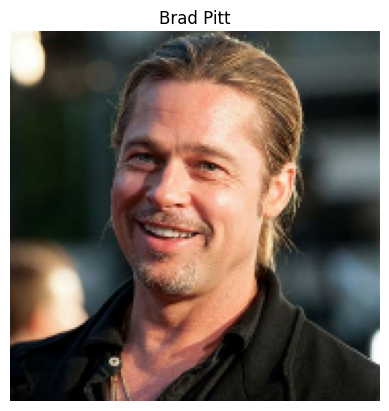

In [123]:
for images, labels in train_dataset:
    for i in range(len(labels)):
        if labels[i] == train_dataset.class_names.index('Brad Pitt'):
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title("Brad Pitt")
            plt.axis("off")
            plt.show()
            break
    break

## 2. Definir una etapa de aumento de datos

Para mejorar la capacidad de generalización del modelo, agregaremos una etapa de **data augmentation**. Esta técnica genera variaciones de las imágenes de entrenamiento para que el modelo sea más robusto frente a diferentes transformaciones en los datos.


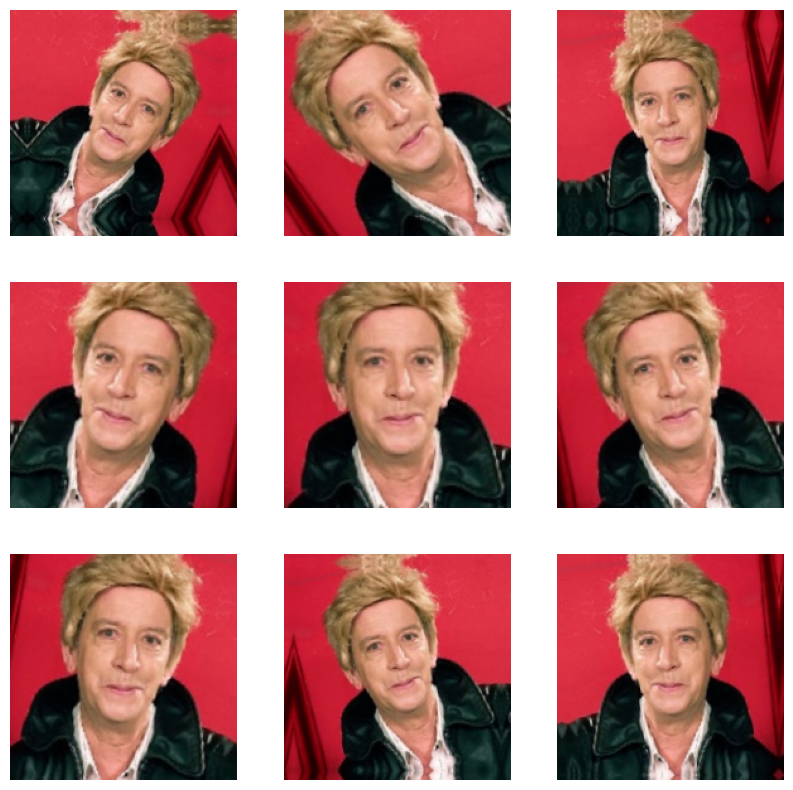

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

img = image.load_img("./brapi.jpg", target_size=(180, 180))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(img_array)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

plt.show()

## 3. Construcción del Modelo Convencional con Dropout

Se hace un rescalado de los valores de los píxeles de las imágenes con valores entre 0 y 1. Se construye un modelo convolucional con varias capas convolucionales de distintos tamaños de filtro (32, 64, 128, 256). Estas capas detectan características de las imágenes, como bordes, texturas y patrones.

Cada capa convolucional es seguida por una capa de Max Pooling con un tamaño de ventana de 2x2, que reduce la dimensionalidad de las características extraídas, disminuyendo la resolución de la imagen pero preservando las características más importantes.

Tras las capas convolucionales, se aplanan las características extraídas en un vector unidimensional. También, se añade una capa de Dropout con un 50% de probabilidad, para evitar overfitting.

In [15]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(categories), activation="softmax")(x)

model_dropout = keras.Model(inputs=inputs, outputs=outputs)

model_dropout.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)

model_dropout.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 17)             │       213,265 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,191,761 (4.55 MB)

 Trainable params: 1,191,761 (4.55 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Entrenamiento del Modelo

Entrenamos el modelo utilizando los datos de entrenamiento y validación.

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="celebrity_faces.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history_dropout = model_dropout.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 32s 675ms/step - accuracy: 0.0760 - loss: 2.9163 - val_accuracy: 0.1111 - val_loss: 2.8161
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 579ms/step - accuracy: 0.1096 - loss: 2.8114 - val_accuracy: 0.1667 - val_loss: 2.7085
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 585ms/step - accuracy: 0.1279 - loss: 2.7442 - val_accuracy: 0.1444 - val_loss: 2.5804
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 584ms/step - accuracy: 0.1356 - loss: 2.7089 - val_accuracy: 0.1889 - val_loss: 2.5295
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 581ms/step - accuracy: 0.1408 - loss: 2.5900 - val_accuracy: 0.1889 - val_loss: 2.4389
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 588ms/step - accuracy: 0.1692 - loss: 2.4558 - val_accuracy: 0.2111 - val_loss: 2.4794
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 30s 663ms/step - accuracy: 0.2026 - loss: 2.3694 - val_accuracy: 0.2111 - val_loss: 2.3049
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 28s 609ms/step - accuracy: 0.2279 - loss: 2.2866 - val_accu

## 5. Visualización del Entrenamiento

Mostramos las curvas de precisión y pérdida durante el entrenamiento.

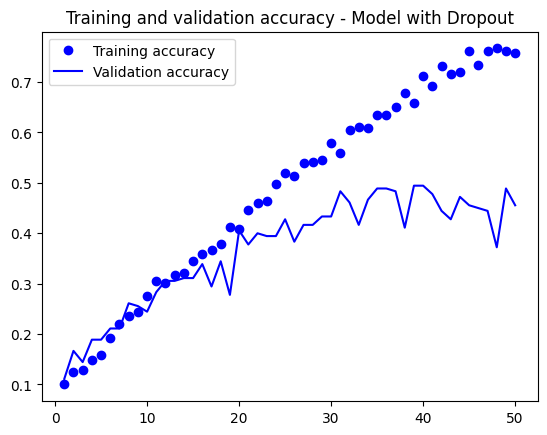

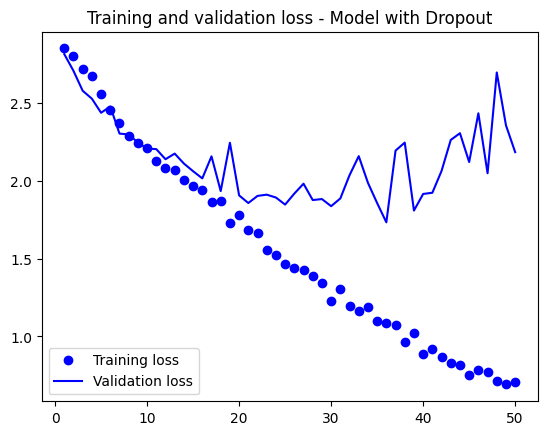

In [17]:
accuracy_dropout = history_dropout.history["accuracy"]
val_accuracy_dropout = history_dropout.history["val_accuracy"]
loss_dropout = history_dropout.history["loss"]
val_loss_dropout = history_dropout.history["val_loss"]

epochs = range(1, len(accuracy_dropout) + 1)

plt.plot(epochs, accuracy_dropout, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy_dropout, "b", label="Validation accuracy")
plt.title("Training and validation accuracy - Model with Dropout")
plt.legend()
plt.show()

plt.plot(epochs, loss_dropout, "bo", label="Training loss")
plt.plot(epochs, val_loss_dropout, "b", label="Validation loss")
plt.title("Training and validation loss - Model with Dropout")
plt.legend()
plt.show()

## 6. Evaluación del Modelo en el Conjunto de Prueba

In [18]:
test_model_dropout = keras.models.load_model("celebrity_faces.keras")
test_loss_dropout, test_acc_dropout = test_model_dropout.evaluate(test_dataset)
print(f"Test accuracy with Dropout: {test_acc_dropout:.3f}")

y_true = []
y_pred_dropout = []

for images, labels in test_dataset:
    y_true.extend(labels)
    preds_dropout = test_model_dropout.predict(images)
    y_pred_dropout.extend(preds_dropout.argmax(axis=1))

print("Classification report for model with Dropout:")
print(classification_report(y_true, y_pred_dropout, target_names=categories))

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 226ms/step - accuracy: 0.3581 - loss: 1.9759
Test accuracy with Dropout: 0.406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Classification report for model with Dropout:
                    precision    recall  f1-score   support

    Angelina Jolie       0.38      0.30      0.33        10
         Brad Pitt       0.22      0.20      0.21        10
 Denzel Washington       0.45      0.50      0.48        10
      Hugh Jackman       0.25      0.10      0.14        10
 Jennifer Lawrence       0.43      0.30      0.35        10
       Johnny Depp       0.50      0.40      0.44        10
      Kate Winslet       0.27      0.30      0.29        10
 Leonardo DiCaprio       0.27      0.60      0.37        10
         Megan Fox       0.60      0.60      0.60        10
   Natalie P

## 7. Comparación con una Red Neuronal con Residual Connections y Batch Normalization

### 7.1 Construcción del Modelo

In [7]:
def residual_block(x, filters, kernel_size=3):
    residual = x
    
    # Ajustamos las dimensiones del camino residual si los filtros no coinciden
    if x.shape[-1] != filters:
        residual = layers.Conv2D(filters, kernel_size=1, padding="same")(residual)
    
    x = layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(filters, kernel_size, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    # Agregar el residual input a la salida de la convolución
    x = layers.add([x, residual])
    x = layers.Activation("relu")(x)
    
    return x

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

# Primera capa convolucional sin residual
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Bloques residuales
x = residual_block(x, filters=64)
x = layers.MaxPooling2D(pool_size=2)(x)

x = residual_block(x, filters=128)
x = layers.MaxPooling2D(pool_size=2)(x)

x = residual_block(x, filters=256)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(categories), activation="softmax")(x)

model_residual = keras.Model(inputs=inputs, outputs=outputs)

model_residual.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)
model_residual.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 180, 180,  │          0 │ sequential[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 178, 178,  │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 89, 89,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 89, 89,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 89, 89,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 89, 89,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 89, 89,    │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 89, 89,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 89, 89,    │      2,112 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 89, 89,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 89, 89,    │          0 │ add[0][0]         │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 44, 44,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 44, 44,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 44, 44,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 44, 44,    │          0 │ batch_normalizat

 Total params: 1,736,657 (6.62 MB)

 Trainable params: 1,734,865 (6.62 MB)

 Non-trainable params: 1,792 (7.00 KB)

### 7.2 Entrenamiento del Modelo

In [8]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="celebrity_faces_with_residual.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]

history_residual = model_residual.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.0864 - loss: 11.8942 - val_accuracy: 0.1333 - val_loss: 2.7783
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 114s 3s/step - accuracy: 0.1406 - loss: 2.7302 - val_accuracy: 0.1556 - val_loss: 2.7818
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.1871 - loss: 2.5424 - val_accuracy: 0.1222 - val_loss: 2.9140
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.2439 - loss: 2.3423 - val_accuracy: 0.1111 - val_loss: 2.9407
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.2734 - loss: 2.1938 - val_accuracy: 0.1056 - val_loss: 2.9559
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.3084 - loss: 2.0815 - val_accuracy: 0.1111 - val_loss: 2.9397
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.3080 - loss: 2.0289 - val_accuracy: 0.1333 - val_loss: 2.8036
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.3510 - loss: 1.9210 - val_accuracy: 0.1500 - v

### 7.3 Visualización del Entrenamiento

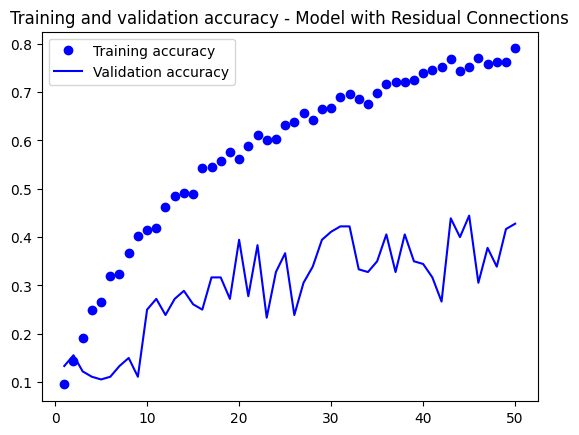

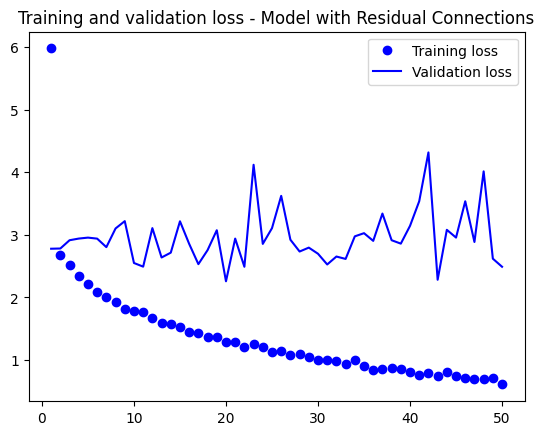

In [9]:
accuracy_residual = history_residual.history["accuracy"]
val_accuracy_residual = history_residual.history["val_accuracy"]
loss_residual = history_residual.history["loss"]
val_loss_residual = history_residual.history["val_loss"]

epochs = range(1, len(accuracy_residual) + 1)

plt.plot(epochs, accuracy_residual, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy_residual, "b", label="Validation accuracy")
plt.title("Training and validation accuracy - Model with Residual Connections")
plt.legend()
plt.show()

plt.plot(epochs, loss_residual, "bo", label="Training loss")
plt.plot(epochs, val_loss_residual, "b", label="Validation loss")
plt.title("Training and validation loss - Model with Residual Connections")
plt.legend()
plt.show()

### 7.4 Evaluación del Modelo en el Conjunto de Prueba

In [10]:
test_model_residual = keras.models.load_model("celebrity_faces_with_residual.keras")
test_loss_residual, test_acc_residual = test_model_residual.evaluate(test_dataset)
print(f"Test accuracy with Residual Connections: {test_acc_residual:.3f}")

y_true = []
y_pred_residual = []

for images, labels in test_dataset:
    y_true.extend(labels)
    preds_residual = test_model_residual.predict(images)
    y_pred_residual.extend(preds_residual.argmax(axis=1))

print("Classification report for model with Residual Connections:")
print(classification_report(y_true, y_pred_residual, target_names=categories))

6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 422ms/step - accuracy: 0.3696 - loss: 2.4028
Test accuracy with Residual Connections: 0.383
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
Classification report for model with Residual Connections:
                    precision    recall  f1-score   support

    Angelina Jolie       0.50      0.50      0.50        10
         Brad Pitt       0.00      0.00      0.00        10
 Denzel Washington       0.43      0.30      0.35        10
      Hugh Jackman       0.18      0.20      0.19        10
 Jennifer Lawrence       0.67      0.20      0.31        10
       Johnny Depp       0.40      0.20      0.27        10
      Kate Winslet       0.42      0.50      0.45        10
 Leonardo DiCaprio       0.25      0.50      0.33        10
         Megan Fox       0.39      0.90      0